## Relatório Projeto  Toyota vs Honda

#### Grupo: Maria Eduarda e Manuela

In [10]:
from pyspark import SparkContext
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.ml.feature import StopWordsRemover
import math

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [44]:
import pandas as pd

#####  Cria conexão com o spark cluster

In [12]:
 sc = SparkContext(appName = "Teste")

##### Download do web-brasil-small  existente no s3 da aws. e "puxamos" para utilizar no spark. O rdd receberá um url da página web e o conteúdo dela.

In [124]:
rdd = sc.sequenceFile("part-00000")

In [24]:
# Count para ver quantas páginas web existem.
N =rdd.count()

In [17]:
result = rdd.take(10)
# cada elemento uma tupla: url e um conteudo

###### Função lambda para filtrar on nomes das empresas escolhidas. 

In [18]:
# riachuelo renner
rdd_to = rdd.filter(lambda x: "toyota" in x[1])
rdd_ho = rdd.filter(lambda x: "honda" in x[1])


In [19]:
rdd_in = rdd_ho.intersection(rdd_to)

In [20]:
# rdd_in.collect()

##### Função para contar a quantidade de vezes que uma palavra aparece.

In [21]:
def conta_palavras(item):
    conteudo = item[1]
    palavras = conteudo.strip().split()
    palvras_filtro_simbolo= [i for i in palavras if any(j.isalpha()for j in i ) ]
    palavras_filtro_len =[i for i in palvras_filtro_simbolo if len(i) >3]

    return [(palavra.lower(), 1) for palavra in palavras_filtro_len]


rdd_toyota= rdd_to.flatMap(conta_palavras).reduceByKey(lambda x,y : x+y)

rdd_honda= rdd_ho.flatMap(conta_palavras).reduceByKey(lambda x,y : x+y)

rdd_intersect= rdd_in.flatMap(conta_palavras).reduceByKey(lambda x,y : x+y)

#####  Cáculo da frequência das palavras.

In [22]:
rdd_freq_to = rdd_to.flatMap(conta_palavras).reduceByKey(lambda x,y : x+y).map(lambda x: (x[0], math.log10(1 + x[1])))

rdd_freq_ho = rdd_ho.flatMap(conta_palavras).reduceByKey(lambda x,y : x+y).map(lambda x: (x[0], math.log10(1 + x[1])))

rdd_freq_in = rdd_in.flatMap(conta_palavras).reduceByKey(lambda x,y : x+y).map(lambda x: (x[0], math.log10(1 + x[1])))

##### Filtragem de palvras muito comuns que não serão úteis para o estudo.

In [25]:
DOC_COUNT_MIN = 5
DOC_COUNT_MAX = 0.7 * N

def filtra_doc_freq(item):
    contagem = item[1]
    return (contagem < DOC_COUNT_MAX) and (contagem >= DOC_COUNT_MIN)


rdd_to_filtrado = rdd_toyota.filter(filtra_doc_freq)
rdd_ho_filtrado = rdd_honda.filter(filtra_doc_freq)
rdd_in_filtrado = rdd_intersect.filter(filtra_doc_freq)

#####  Cálculo do idf da palavra

In [26]:
def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(N / contagem)
    return (palavra, idf)

rdd_idf_to = rdd_to_filtrado.map(computa_idf)
rdd_idf_ho = rdd_ho_filtrado.map(computa_idf)
rdd_idf_in = rdd_in_filtrado.map(computa_idf)

In [27]:
# rdd_teste.collect()

##### Cálculo da relevância da palavra

In [143]:
 rdd_to_rel =  rdd_freq_to.join(rdd_idf_to).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])

In [144]:
 rdd_ho_rel = rdd_freq_ho.join(rdd_idf_ho).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])

In [30]:
 rdd_in_rel = rdd_freq_in.join(rdd_idf_in).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(20, key=lambda x: -x[1])

#####  Tabela das 100 palavras mais relevantes em paginas onde o Toyota e Honda aparecem conjuntamente


In [145]:
#  rdd_in_rel

#####  Tabela das 100 palavras mais relevantes em paginas onde a palavra  Renner  aparece

In [146]:
#  rdd_ho_rel

#####  Tabela das 100 palavras mais relevantes em paginas onde a palavra  Riachuelo  aparece

In [147]:
#  rdd_to_rel

In [125]:
with open("in.txt", "w", encoding ="utf-8") as arq:
    arq.write("palavra:peso\n")
    for linha in  rdd_in_rel:
        arq.write(f"{linha[0]}:{linha[1]}\n")

with open("toyota.txt", "w", encoding ="utf-8") as arq:
    arq.write("palavra:peso\n")
    for linha in  rdd_to_rel:
        arq.write(f"{linha[0]}:{linha[1]}\n")

with open("honda.txt", "w", encoding ="utf-8") as arq:
    arq.write("palavra:peso\n")
    for linha in  rdd_ho_rel:
        arq.write(f"{linha[0]}:{linha[1]}\n")


In [126]:
datain = pd.read_csv("in.txt", sep=":")
datatoyo = pd.read_csv("toyota.txt", sep=":")
datahonda = pd.read_csv("honda.txt", sep=":")

In [ ]:
datain

In [127]:
datatoyo

,palavra,peso
0,motor,5.198862
1,janeiro,5.198861
2,como,5.197756
3,blindado,5.197456
4,carros,5.196944
5,chassis,5.196515
6,toyota,5.196154
7,classe,5.194228
8,está,5.192818
9,muito,5.192381


In [128]:
datahonda

,palavra,peso
0,motor,5.198845
1,pelo,5.198783
2,conserto,5.198679
3,fiat,5.198613
4,golf,5.198144
5,sport,5.197610
6,editora,5.197584
7,blindado,5.197293
8,chassis,5.196515
9,manutenção,5.195986


##### Word cloud

In [34]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [129]:
with open("interseccao.txt", "w", encoding ="utf-8") as arq:
    arq.write("palavra\n")
    for linha in  rdd_in_rel:
        arq.write(f"{linha[0]},")
with open("toyocloud.txt", "w", encoding ="utf-8") as arq:
    arq.write("palavra\n")
    for linha in  rdd_to_rel:
        arq.write(f"{linha[0]},")
with open("hondacloud.txt", "w", encoding ="utf-8") as arq:
    arq.write("palavra\n")
    for linha in  rdd_ho_rel:
        arq.write(f"{linha[0]},")        


In [130]:
df= pd.read_csv("interseccao.txt", sep=":")
dt=pd.read_csv("toyocloud.txt", sep=":")
dh=pd.read_csv("hondacloud.txt", sep=":")

In [98]:
# pl = " ".join(review for review in df[df["country"]=="US"].description)

In [120]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='magma', collocations=False, stopwords = STOPWORDS).generate(df.palavra[0])

In [139]:
wordcloud.to_file("interseccaocloud.png")

In [131]:
wordcloudto = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='magma', collocations=False, stopwords = STOPWORDS).generate(dt.palavra[0])

In [141]:
wordcloudto.to_file("toyotacloud.png")

In [133]:
wordcloudho = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='magma', collocations=False, stopwords = STOPWORDS).generate(dh.palavra[0])

In [142]:
wordcloudho.to_file("hondacloud.png")

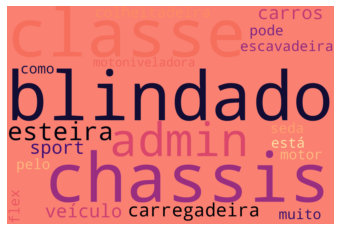

In [122]:
plt.imshow(wordcloud, interpolation ="bilinear")
plt.axis("off")
# plt.figure(figsize=(8000,2000))
plt.show()

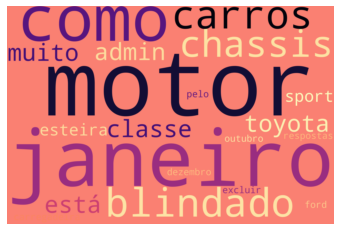

In [134]:
plt.imshow(wordcloudto, interpolation ="bilinear")
plt.axis("off")
# plt.figure(figsize=(8000,2000))
plt.show()

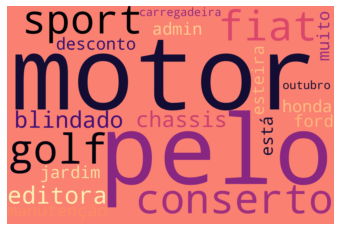

In [136]:
plt.imshow(wordcloudho, interpolation ="bilinear")
plt.axis("off")
# plt.figure(figsize=(8000,2000))
plt.show()